# Exploratory Data Analysis - Radar data and weather data

## 1. Loading packages and libraries

In [1]:
# For data manipulation
import pandas as pd
import numpy as np

# For visualisations
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.dates as mdates

# For UML
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
df_bikelane = pd.read_csv('/workspaces/2nd_semester_project/notebooks/bikelane_historic_data.csv') # The path to the dataset should probably be changed when we're setting up the serverless-ml-pipeline
df_building = pd.read_csv('/workspaces/2nd_semester_project/notebooks/bikelane_historic_data.csv')

In [3]:
df_bikelane.head()

,time,battery,temperature,x,y,z,0_radar,1_radar,2_radar,3_radar,4_radar,5_radar,6_radar,7_radar,package_type,f_cnt,dr,snr,rssi,hw_fw_version
0,2024-03-01 00:00:32.251000,NaN,5.25,-253,-27,-630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PackageType.HEART_BEAT,1459,4,2.5,-86,DataVersion.HW_2FW2_X_X
1,2024-03-01 00:10:32.251000,3.04,5.25,-254,-20,-627,6.0,6.0,6.0,6.0,7.0,7.0,7.0,4.0,PackageType.HEART_BEAT,1459,4,2.5,-86,DataVersion.HW_2FW2_X_X
2,2024-03-01 00:20:33.352000,NaN,5.25,-254,-23,-635,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PackageType.HEART_BEAT,1460,4,NaN,-91,DataVersion.HW_2FW2_X_X
3,2024-03-01 00:30:34.352000,NaN,5.25,-256,-25,-628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PackageType.HEART_BEAT,1460,4,NaN,-91,DataVersion.HW_2FW2_X_X
4,2024-03-01 00:40:33.352000,3.04,5.25,-253,-28,-630,5.0,5.0,5.0,5.0,6.0,6.0,6.0,6.0,PackageType.HEART_BEAT,1460,4,NaN,-91,DataVersion.HW_2FW2_X_X


In [4]:
df_building.head()

,time,battery,temperature,x,y,z,0_radar,1_radar,2_radar,3_radar,4_radar,5_radar,6_radar,7_radar,package_type,f_cnt,dr,snr,rssi,hw_fw_version
0,2024-03-01 00:00:32.251000,NaN,5.25,-253,-27,-630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PackageType.HEART_BEAT,1459,4,2.5,-86,DataVersion.HW_2FW2_X_X
1,2024-03-01 00:10:32.251000,3.04,5.25,-254,-20,-627,6.0,6.0,6.0,6.0,7.0,7.0,7.0,4.0,PackageType.HEART_BEAT,1459,4,2.5,-86,DataVersion.HW_2FW2_X_X
2,2024-03-01 00:20:33.352000,NaN,5.25,-254,-23,-635,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PackageType.HEART_BEAT,1460,4,NaN,-91,DataVersion.HW_2FW2_X_X
3,2024-03-01 00:30:34.352000,NaN,5.25,-256,-25,-628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PackageType.HEART_BEAT,1460,4,NaN,-91,DataVersion.HW_2FW2_X_X
4,2024-03-01 00:40:33.352000,3.04,5.25,-253,-28,-630,5.0,5.0,5.0,5.0,6.0,6.0,6.0,6.0,PackageType.HEART_BEAT,1460,4,NaN,-91,DataVersion.HW_2FW2_X_X


In [5]:
# getting weather data from the same period
import openmeteo_requests
import requests_cache
from retry_requests import retry

In [6]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

In [7]:
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 57.01,
	"longitude": 9.99,
	"start_date": "2024-03-01",
	"end_date": "2024-04-30",
	"hourly": ["temperature_2m", "relative_humidity_2m", "precipitation", "surface_pressure", "cloud_cover", "wind_speed_10m", "wind_direction_10m", "wind_gusts_10m", "soil_temperature_0_to_7cm", "soil_temperature_7_to_28cm", "soil_moisture_0_to_7cm", "soil_moisture_7_to_28cm"]
}
responses = openmeteo.weather_api(url, params=params)


In [8]:
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
hourly_precipitation = hourly.Variables(2).ValuesAsNumpy()
hourly_surface_pressure = hourly.Variables(3).ValuesAsNumpy()
hourly_cloud_cover = hourly.Variables(4).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(5).ValuesAsNumpy()
hourly_wind_direction_10m = hourly.Variables(6).ValuesAsNumpy()
hourly_wind_gusts_10m = hourly.Variables(7).ValuesAsNumpy()
hourly_soil_temperature_0_to_7cm = hourly.Variables(8).ValuesAsNumpy()
hourly_soil_temperature_7_to_28cm = hourly.Variables(9).ValuesAsNumpy()
hourly_soil_moisture_0_to_7cm = hourly.Variables(10).ValuesAsNumpy()
hourly_soil_moisture_7_to_28cm = hourly.Variables(11).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
hourly_data["precipitation"] = hourly_precipitation
hourly_data["surface_pressure"] = hourly_surface_pressure
hourly_data["cloud_cover"] = hourly_cloud_cover
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
hourly_data["wind_direction_10m"] = hourly_wind_direction_10m
hourly_data["wind_gusts_10m"] = hourly_wind_gusts_10m
hourly_data["soil_temperature_0_to_7cm"] = hourly_soil_temperature_0_to_7cm
hourly_data["soil_temperature_7_to_28cm"] = hourly_soil_temperature_7_to_28cm
hourly_data["soil_moisture_0_to_7cm"] = hourly_soil_moisture_0_to_7cm
hourly_data["soil_moisture_7_to_28cm"] = hourly_soil_moisture_7_to_28cm

hourly_dataframe = pd.DataFrame(data = hourly_data)
print(hourly_dataframe)

Coordinates 56.977149963378906°N 10.0632905960083°E
Elevation 23.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
                          date  temperature_2m  relative_humidity_2m  \
0    2024-03-01 00:00:00+00:00        6.230500             87.634949   
1    2024-03-01 01:00:00+00:00        5.730500             88.205788   
2    2024-03-01 02:00:00+00:00        5.230500             89.097878   
3    2024-03-01 03:00:00+00:00        4.780500             90.966789   
4    2024-03-01 04:00:00+00:00        3.680500             94.174324   
...                        ...             ...                   ...   
1459 2024-04-30 19:00:00+00:00       13.330501             65.643143   
1460 2024-04-30 20:00:00+00:00       13.130500             67.884193   
1461 2024-04-30 21:00:00+00:00       12.980500             68.085487   
1462 2024-04-30 22:00:00+00:00       12.330501             68.184601   
1463 2024-04-30 23:00:00+00:00       11.580501             70.416718   

      prec

In [9]:
#remove the timezone from the date column
hourly_dataframe['date'] = hourly_dataframe['date'].dt.tz_localize(None)
#Convert to datetime object
hourly_dataframe['date'] = pd.to_datetime(hourly_dataframe['date'])

In [10]:
# Convert the 'time' column to datetime, coercing errors to NaT
df_building['time'] = pd.to_datetime(df_building['time'], errors='coerce')
df_bikelane['time'] = pd.to_datetime(df_bikelane['time'], errors='coerce')
# Remove rows where the 'time' column is NaT
df_building = df_building.dropna(subset=['time'])
df_bikelane = df_bikelane.dropna(subset=['time'])

In [11]:
#create a column for the time in the format of "YYYY-MM-DD HH" to merge with weather data
df_bikelane['time_hour'] = df_bikelane['time'].dt.strftime('%Y-%m-%d %H')
df_building['time_hour'] = df_building['time'].dt.strftime('%Y-%m-%d %H')
# Converting the time_hour column to datetime
df_bikelane['time_hour'] = pd.to_datetime(df_bikelane['time_hour'])
df_building['time_hour'] = pd.to_datetime(df_building['time_hour'])

In [12]:
# Changing the time and time_hour columns to datetime
df_bikelane['time'] = pd.to_datetime(df_bikelane['time'])
df_bikelane['time_hour'] = pd.to_datetime(df_bikelane['time_hour'])
df_building['time'] = pd.to_datetime(df_building['time'])
df_building['time_hour'] = pd.to_datetime(df_building['time_hour'])

In [13]:
print(df_bikelane.info())
print(df_building.info())

<class 'pandas.core.frame.DataFrame'>
Index: 7047 entries, 0 to 7064
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   time           7047 non-null   datetime64[ns]
 1   battery        2441 non-null   float64       
 2   temperature    7047 non-null   float64       
 3   x              7047 non-null   int64         
 4   y              7047 non-null   int64         
 5   z              7047 non-null   int64         
 6   0_radar        2441 non-null   float64       
 7   1_radar        2441 non-null   float64       
 8   2_radar        2441 non-null   float64       
 9   3_radar        2441 non-null   float64       
 10  4_radar        2441 non-null   float64       
 11  5_radar        2441 non-null   float64       
 12  6_radar        2441 non-null   float64       
 13  7_radar        2441 non-null   float64       
 14  package_type   7047 non-null   object        
 15  f_cnt          7047 non-nu

In [14]:
# Merging the weather data with the building sensor data
df_building = df_building.merge(hourly_dataframe, left_on='time_hour', right_on='date', how='left')
# Merging the weather data with the bikelane sensor data
df_bikelane = df_bikelane.merge(hourly_dataframe, left_on='time_hour', right_on='date', how='left')

In [15]:
# removing date column
df_building = df_building.drop(columns=['date'])
df_bikelane = df_bikelane.drop(columns=['date'])

In [16]:
print(df_bikelane.info())
print(df_building.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7047 entries, 0 to 7046
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   time                        7047 non-null   datetime64[ns]
 1   battery                     2441 non-null   float64       
 2   temperature                 7047 non-null   float64       
 3   x                           7047 non-null   int64         
 4   y                           7047 non-null   int64         
 5   z                           7047 non-null   int64         
 6   0_radar                     2441 non-null   float64       
 7   1_radar                     2441 non-null   float64       
 8   2_radar                     2441 non-null   float64       
 9   3_radar                     2441 non-null   float64       
 10  4_radar                     2441 non-null   float64       
 11  5_radar                     2441 non-null   float64     

In [17]:
# backfilling radar data
# backfill missing values in radar columns and battery column with the previous value
df_building['0_radar'] = df_building['0_radar'].bfill()
df_building['1_radar'] = df_building['1_radar'].bfill()
df_building['2_radar'] = df_building['2_radar'].bfill()
df_building['3_radar'] = df_building['3_radar'].bfill()
df_building['4_radar'] = df_building['4_radar'].bfill()
df_building['5_radar'] = df_building['5_radar'].bfill()
df_building['6_radar'] = df_building['6_radar'].bfill()
df_building['7_radar'] = df_building['7_radar'].bfill()
df_building['battery'] = df_building['battery'].bfill()
df_bikelane['0_radar'] = df_bikelane['0_radar'].bfill()
df_bikelane['1_radar'] = df_bikelane['1_radar'].bfill()
df_bikelane['2_radar'] = df_bikelane['2_radar'].bfill()
df_bikelane['3_radar'] = df_bikelane['3_radar'].bfill()
df_bikelane['4_radar'] = df_bikelane['4_radar'].bfill()
df_bikelane['5_radar'] = df_bikelane['5_radar'].bfill()
df_bikelane['6_radar'] = df_bikelane['6_radar'].bfill()
df_bikelane['7_radar'] = df_bikelane['7_radar'].bfill()
df_bikelane['battery'] = df_bikelane['battery'].bfill()


In [18]:
# Making a new column including only the date from the 'time' variable
df_building['date'] = df_building['time'].dt.date
df_bikelane['date'] = df_bikelane['time'].dt.date
# Making a new column including only the hour from the 'time' variable
df_building['hour'] = df_building['time'].dt.hour
df_bikelane['hour'] = df_bikelane['time'].dt.hour
# Making a new column including the day of week from the 'time' variable
df_building['day_of_week'] = df_building['time'].dt.dayofweek
df_bikelane['day_of_week'] = df_bikelane['time'].dt.dayofweek
# And another column containing the name of the day
df_building['day_name'] = df_building['time'].dt.day_name()
df_bikelane['day_name'] = df_bikelane['time'].dt.day_name()

In [19]:
# Checking how these new variables look
df_building[['time','date', 'hour', 'day_of_week', 'day_name']].sample(10)

,time,date,hour,day_of_week,day_name
5743,2024-04-20 10:02:15.573,2024-04-20,10,5,Saturday
5048,2024-04-13 21:48:23.261,2024-04-13,21,5,Saturday
6388,2024-04-25 05:38:07.279,2024-04-25,5,3,Thursday
891,2024-03-07 22:09:44.178,2024-03-07,22,3,Thursday
2361,2024-03-21 06:00:35.261,2024-03-21,6,3,Thursday
3786,2024-04-03 21:17:50.581,2024-04-03,21,2,Wednesday
7042,2024-04-29 23:10:06.597,2024-04-29,23,0,Monday
841,2024-03-07 13:35:09.605,2024-03-07,13,3,Thursday
4546,2024-04-10 01:56:04.585,2024-04-10,1,2,Wednesday
456,2024-03-04 13:14:36.752,2024-03-04,13,0,Monday


In [20]:
df_bikelane[['time','date', 'hour', 'day_of_week', 'day_name']].sample(10)

,time,date,hour,day_of_week,day_name
4893,2024-04-12 19:51:17.261,2024-04-12,19,4,Friday
5390,2024-04-17 16:37:22.266,2024-04-17,16,2,Wednesday
1982,2024-03-17 21:02:15.856,2024-03-17,21,6,Sunday
4618,2024-04-10 17:02:35.166,2024-04-10,17,2,Wednesday
4683,2024-04-11 04:22:24.252,2024-04-11,4,3,Thursday
4812,2024-04-12 04:07:31.346,2024-04-12,4,4,Friday
5288,2024-04-16 19:50:53.409,2024-04-16,19,1,Tuesday
2814,2024-03-24 20:45:27.038,2024-03-24,20,6,Sunday
322,2024-03-03 09:49:33.719,2024-03-03,9,6,Sunday
447,2024-03-04 10:20:29.199,2024-03-04,10,0,Monday


## 5. Exploratory Data Analysis

Now we'll start on the EDA. Firstly, we'll look at the descriptive statistics for all of the numeric columns. For this we'll use the pandas describe command.

In [21]:
df_building.describe()

,time,battery,temperature,x,y,z,0_radar,1_radar,2_radar,3_radar,...,cloud_cover,wind_speed_10m,wind_direction_10m,wind_gusts_10m,soil_temperature_0_to_7cm,soil_temperature_7_to_28cm,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,hour,day_of_week
count,7047,7046.000000,7047.000000,7047.000000,7047.000000,7047.000000,7046.000000,7046.000000,7046.000000,7046.000000,...,7047.000000,7047.000000,7047.000000,7047.000000,7047.000000,7047.000000,7047.000000,7047.000000,7047.000000,7047.000000
mean,2024-03-31 11:57:51.588065536,3.057988,6.867710,-213.281396,0.457216,-595.645949,15.850270,14.446778,14.719131,12.782856,...,67.868073,14.074438,155.849518,29.015581,5.928152,5.786340,0.257529,0.257042,11.692777,3.058465
min,2024-03-01 00:00:32.251000,3.040000,-2.250000,-547.000000,-1007.000000,-1475.000000,3.000000,3.000000,3.000000,3.000000,...,0.000000,0.360000,1.847571,3.600000,-0.069500,1.480500,0.197000,0.210000,0.000000,0.000000
25%,2024-03-16 00:39:33.854000128,3.060000,3.875000,-257.000000,-27.000000,-683.000000,5.000000,5.000000,5.000000,5.000000,...,32.700001,9.107359,90.000000,19.440001,3.730500,4.355500,0.240000,0.242000,5.000000,1.000000
50%,2024-04-01 07:19:35.713999872,3.060000,6.000000,-212.000000,-20.000000,-604.000000,6.000000,6.000000,6.000000,6.000000,...,89.399994,14.113653,130.814987,29.160000,5.630500,5.630500,0.256000,0.258000,12.000000,3.000000
75%,2024-04-16 19:15:58.208000,3.060000,9.000000,-169.000000,-8.000000,-510.000000,7.000000,7.000000,6.000000,7.000000,...,100.000000,17.877180,226.847595,36.719997,8.030500,6.980500,0.272000,0.272000,18.000000,5.000000
max,2024-04-29 23:50:04.407000,3.080000,30.500000,288.000000,786.000000,16.000000,173.000000,182.000000,236.000000,151.000000,...,100.000000,39.081146,360.000000,85.320000,14.730500,10.880500,0.355000,0.317000,23.000000,6.000000
std,NaN,0.011555,4.645321,83.668190,135.036219,168.422165,26.763144,23.096458,24.891353,20.397260,...,36.184715,6.020104,87.008072,12.481932,3.071316,2.134909,0.025418,0.023597,7.168503,2.025312


In [22]:
df_bikelane.describe()

,time,battery,temperature,x,y,z,0_radar,1_radar,2_radar,3_radar,...,cloud_cover,wind_speed_10m,wind_direction_10m,wind_gusts_10m,soil_temperature_0_to_7cm,soil_temperature_7_to_28cm,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,hour,day_of_week
count,7047,7046.000000,7047.000000,7047.000000,7047.000000,7047.000000,7046.000000,7046.000000,7046.000000,7046.000000,...,7047.000000,7047.000000,7047.000000,7047.000000,7047.000000,7047.000000,7047.000000,7047.000000,7047.000000,7047.000000
mean,2024-03-31 11:57:51.588065536,3.057988,6.867710,-213.281396,0.457216,-595.645949,15.850270,14.446778,14.719131,12.782856,...,67.868073,14.074438,155.849518,29.015581,5.928152,5.786340,0.257529,0.257042,11.692777,3.058465
min,2024-03-01 00:00:32.251000,3.040000,-2.250000,-547.000000,-1007.000000,-1475.000000,3.000000,3.000000,3.000000,3.000000,...,0.000000,0.360000,1.847571,3.600000,-0.069500,1.480500,0.197000,0.210000,0.000000,0.000000
25%,2024-03-16 00:39:33.854000128,3.060000,3.875000,-257.000000,-27.000000,-683.000000,5.000000,5.000000,5.000000,5.000000,...,32.700001,9.107359,90.000000,19.440001,3.730500,4.355500,0.240000,0.242000,5.000000,1.000000
50%,2024-04-01 07:19:35.713999872,3.060000,6.000000,-212.000000,-20.000000,-604.000000,6.000000,6.000000,6.000000,6.000000,...,89.399994,14.113653,130.814987,29.160000,5.630500,5.630500,0.256000,0.258000,12.000000,3.000000
75%,2024-04-16 19:15:58.208000,3.060000,9.000000,-169.000000,-8.000000,-510.000000,7.000000,7.000000,6.000000,7.000000,...,100.000000,17.877180,226.847595,36.719997,8.030500,6.980500,0.272000,0.272000,18.000000,5.000000
max,2024-04-29 23:50:04.407000,3.080000,30.500000,288.000000,786.000000,16.000000,173.000000,182.000000,236.000000,151.000000,...,100.000000,39.081146,360.000000,85.320000,14.730500,10.880500,0.355000,0.317000,23.000000,6.000000
std,NaN,0.011555,4.645321,83.668190,135.036219,168.422165,26.763144,23.096458,24.891353,20.397260,...,36.184715,6.020104,87.008072,12.481932,3.071316,2.134909,0.025418,0.023597,7.168503,2.025312


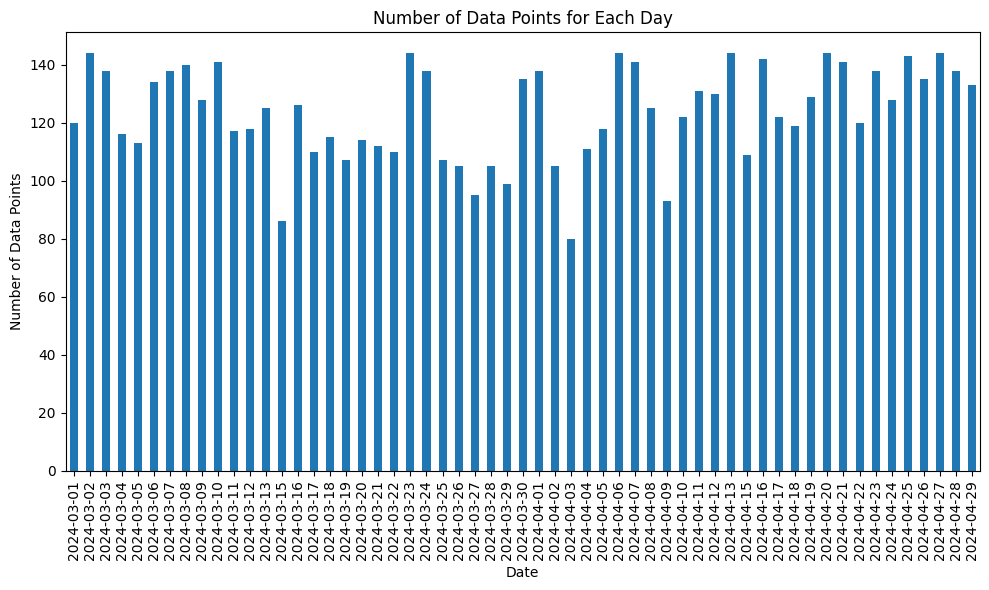

In [23]:
# Grouping by date and counting the number of data points
daily_counts = df_bikelane.groupby('date').size()

# Plotting the number of data points for each day using plt
plt.figure(figsize=(10, 6))
daily_counts.plot(kind='bar')
plt.title('Number of Data Points for Each Day')
plt.xlabel('Date')
plt.ylabel('Number of Data Points')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

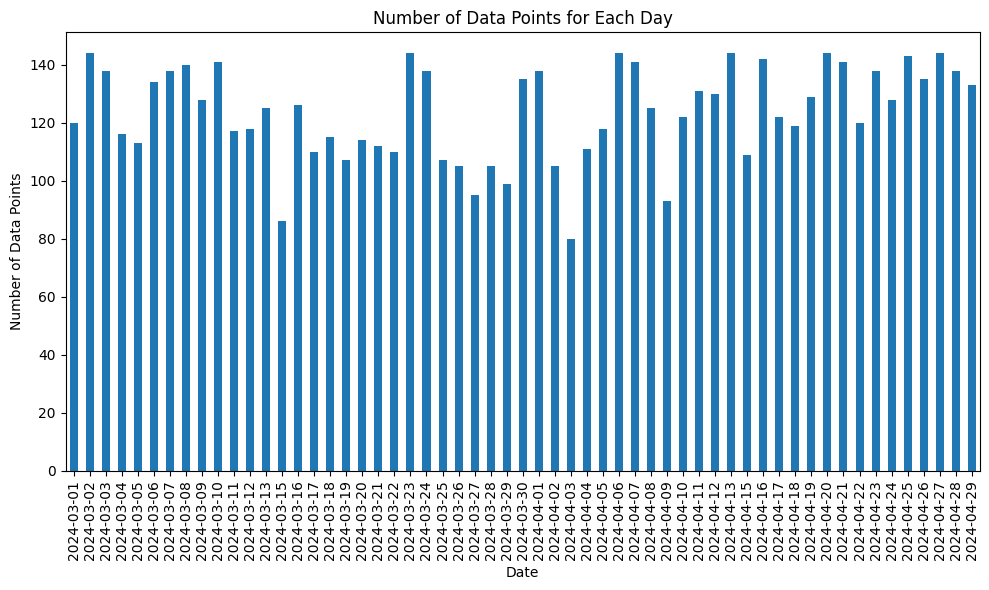

In [24]:
# Grouping by date and counting the number of data points
daily_counts = df_building.groupby('date').size()

# Plotting the number of data points for each day using plt
plt.figure(figsize=(10, 6))
daily_counts.plot(kind='bar')
plt.title('Number of Data Points for Each Day')
plt.xlabel('Date')
plt.ylabel('Number of Data Points')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [25]:
# Convert 'package_type' to numeric codes
df_building['package_type_encoded'] = pd.Categorical(df_building['package_type']).codes
df_building['package_type_encoded'].head()

0    1
1    1
2    1
3    1
4    1
Name: package_type_encoded, dtype: int8

In [26]:
# Convert 'package_type' to numeric codes
df_bikelane['package_type_encoded'] = pd.Categorical(df_bikelane['package_type']).codes
df_bikelane['package_type_encoded'].head()

0    1
1    1
2    1
3    1
4    1
Name: package_type_encoded, dtype: int8

In [27]:
#Renaming the radar columns to start with radar to deal with hopsworks problem
df_building = df_building.rename(columns={'0_radar': 'radar_0', '1_radar': 'radar_1', '2_radar': 'radar_2', '3_radar': 'radar_3', '4_radar': 'radar_4', '5_radar': 'radar_5', '6_radar': 'radar_6', '7_radar': 'radar_7'})
df_bikelane = df_bikelane.rename(columns={'0_radar': 'radar_0', '1_radar': 'radar_1', '2_radar': 'radar_2', '3_radar': 'radar_3', '4_radar': 'radar_4', '5_radar': 'radar_5', '6_radar': 'radar_6', '7_radar': 'radar_7'})


### Checking correlations of features

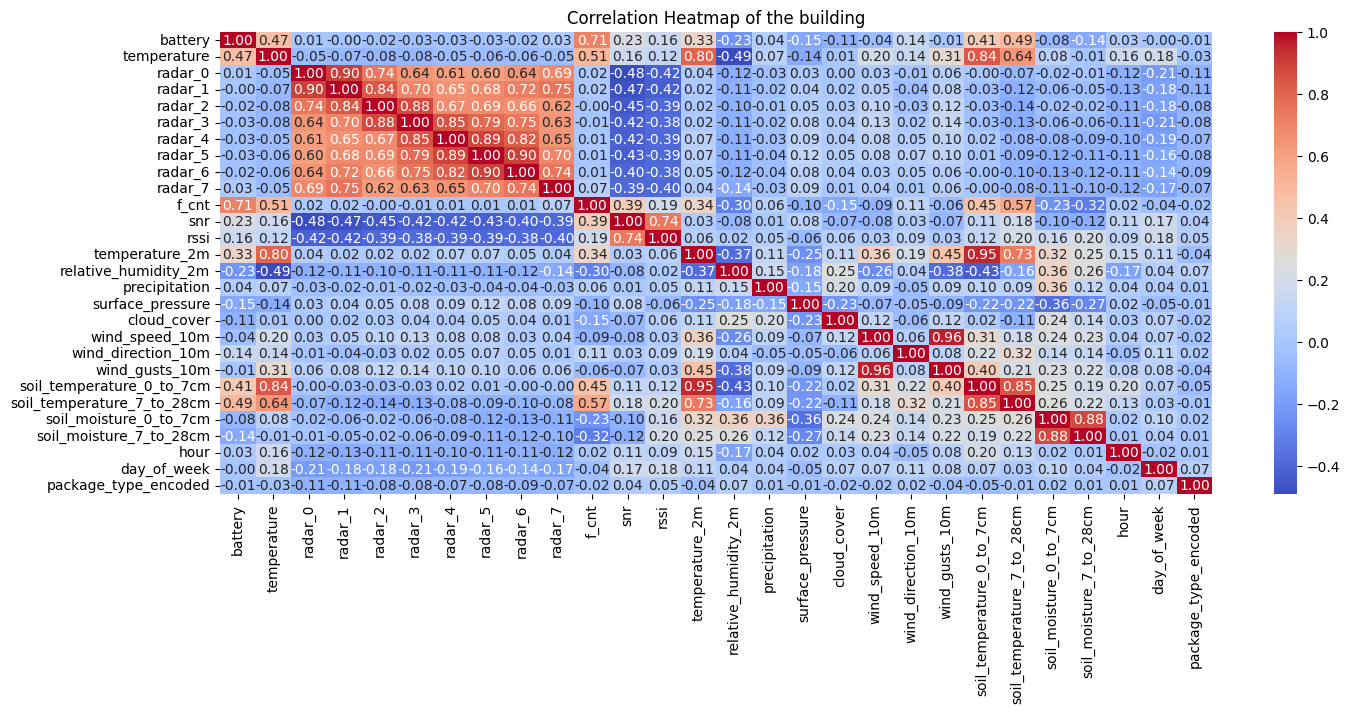

In [28]:
# Calculating correlation matrix with all the values that are not categorical
correlation_matrix = df_building[['battery', 'temperature', 'radar_0', 'radar_1', 'radar_2', 'radar_3', 'radar_4', 'radar_5', 'radar_6', 'radar_7', 'f_cnt', 'snr', 'rssi', "temperature_2m", "relative_humidity_2m", "precipitation", "surface_pressure", "cloud_cover", "wind_speed_10m", "wind_direction_10m", "wind_gusts_10m", "soil_temperature_0_to_7cm", "soil_temperature_7_to_28cm", "soil_moisture_0_to_7cm", "soil_moisture_7_to_28cm", 'hour', 'day_of_week', 'package_type_encoded']].corr()

# Plotting heatmap
plt.figure(figsize=(16, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of the building')
plt.show()

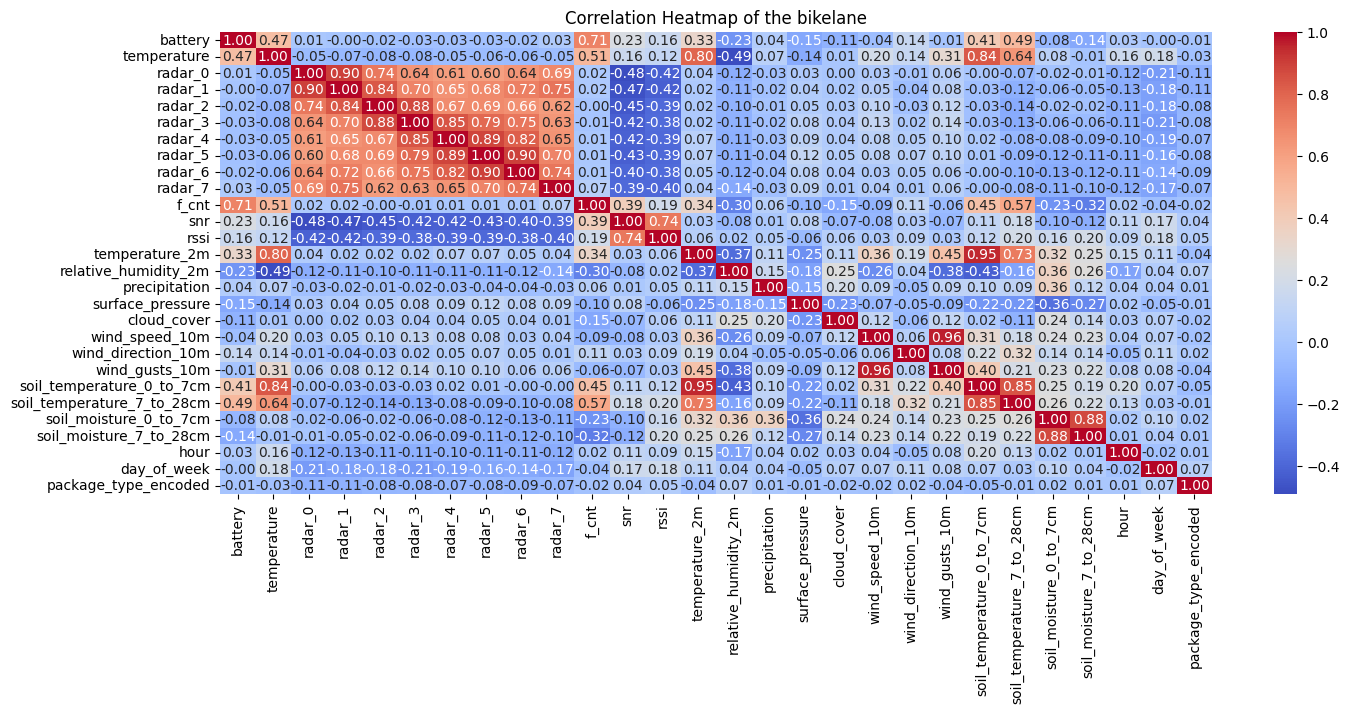

In [29]:
# Calculating correlation matrix with all the values that are not categorical
correlation_matrix_1 = df_bikelane[['battery', 'temperature', 'radar_0', 'radar_1', 'radar_2', 'radar_3', 'radar_4', 'radar_5', 'radar_6', 'radar_7', 'f_cnt', 'snr', 'rssi', "temperature_2m", "relative_humidity_2m", "precipitation", "surface_pressure", "cloud_cover", "wind_speed_10m", "wind_direction_10m", "wind_gusts_10m", "soil_temperature_0_to_7cm", "soil_temperature_7_to_28cm", "soil_moisture_0_to_7cm", "soil_moisture_7_to_28cm", 'hour', 'day_of_week', 'package_type_encoded']].corr()

# Plotting heatmap
plt.figure(figsize=(16, 6))
sns.heatmap(correlation_matrix_1, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of the bikelane')
plt.show()

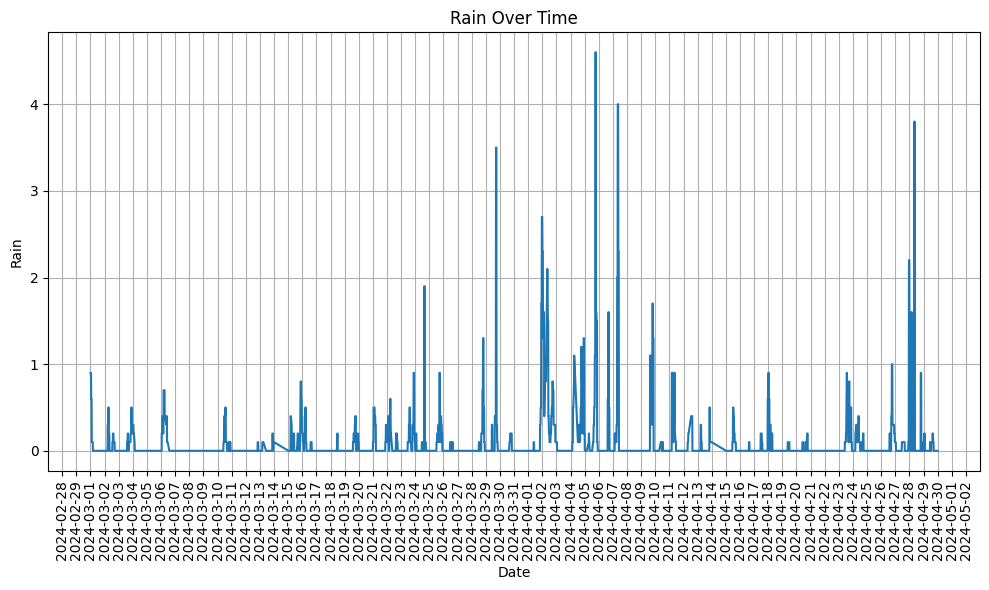

In [42]:
#Finding rainy days 

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_building['time'], df_building['precipitation'], linestyle='-')
plt.title('Rain Over Time')
plt.xlabel('Date')
plt.ylabel('Rain')
plt.xticks(rotation=90)
plt.grid(True)

# Set x-axis major locator and formatter
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.tight_layout()
plt.show()

/tmp/ipykernel_52897/2590097495.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_specific_time_range[['radar_0', 'radar_1', 'radar_2', 'radar_3', 'radar_4', 'radar_5', 'radar_6', 'radar_7']] = normalized_data


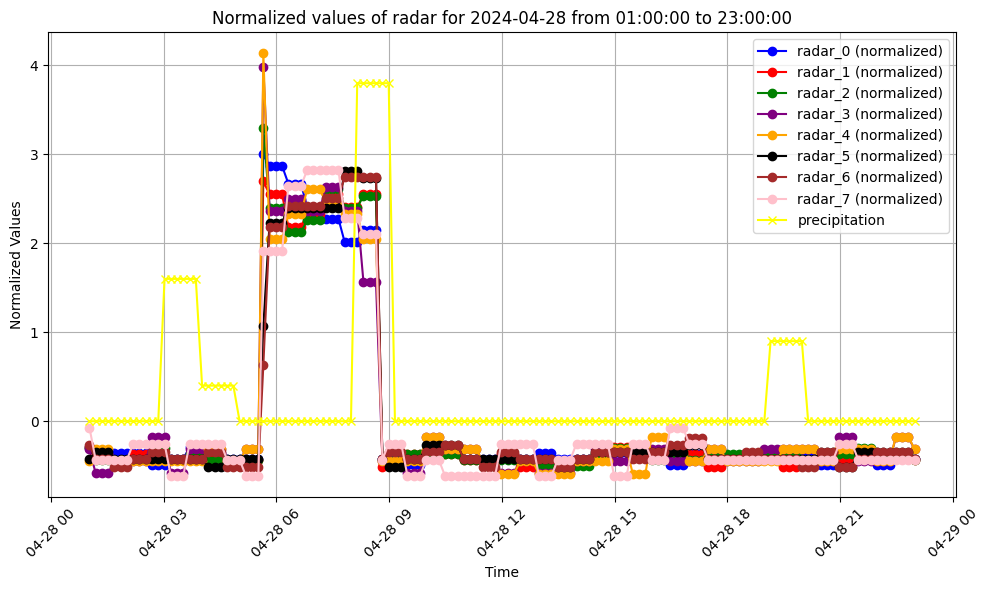

In [43]:
# Convert 'time' column to datetime if it's not already in datetime format
df_building['time'] = pd.to_datetime(df_building['time'])

# Specify the date and time range
specific_date = '2024-04-28'
start_time = '01:00:00'
end_time = '23:00:00'

# Filter the DataFrame for the specific date and time range
df_specific_time_range = df_building[(df_building['time'].dt.date == pd.to_datetime(specific_date).date()) &
                            (df_building['time'].dt.time >= pd.to_datetime(start_time).time()) &
                            (df_building['time'].dt.time <= pd.to_datetime(end_time).time())]

# Selecting the columns to be normalized
data_to_normalize = df_specific_time_range[['radar_0', 'radar_1', 'radar_2', 'radar_3', 'radar_4', 'radar_5', 'radar_6', 'radar_7']]

# Applying StandardScaler
scaler = StandardScaler()
normalized_data = scaler.fit_transform(data_to_normalize)

# Adding normalized data back to the DataFrame
df_specific_time_range[['radar_0', 'radar_1', 'radar_2', 'radar_3', 'radar_4', 'radar_5', 'radar_6', 'radar_7']] = normalized_data

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_specific_time_range['time'], df_specific_time_range['radar_0'], label='radar_0 (normalized)', color='blue', marker='o', linestyle='-')
plt.plot(df_specific_time_range['time'], df_specific_time_range['radar_1'], label='radar_1 (normalized)', color='red', marker='o', linestyle='-')
plt.plot(df_specific_time_range['time'], df_specific_time_range['radar_2'], label='radar_2 (normalized)', color='green', marker='o', linestyle='-')
plt.plot(df_specific_time_range['time'], df_specific_time_range['radar_3'], label='radar_3 (normalized)', color='purple', marker='o', linestyle='-')
plt.plot(df_specific_time_range['time'], df_specific_time_range['radar_4'], label='radar_4 (normalized)', color='orange', marker='o', linestyle='-')
plt.plot(df_specific_time_range['time'], df_specific_time_range['radar_5'], label='radar_5 (normalized)', color='black', marker='o', linestyle='-')
plt.plot(df_specific_time_range['time'], df_specific_time_range['radar_6'], label='radar_6 (normalized)', color='brown', marker='o', linestyle='-')
plt.plot(df_specific_time_range['time'], df_specific_time_range['radar_7'], label='radar_7 (normalized)', color='pink', marker='o', linestyle='-')

#plotting rain
plt.plot(df_specific_time_range['time'], df_specific_time_range['precipitation'], label='precipitation', color='yellow', marker='x', linestyle='-')

plt.title(f'Normalized values of radar for {specific_date} from {start_time} to {end_time}')
plt.xlabel('Time')
plt.ylabel('Normalized Values')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
